### Flowchart of Performance Evaluation

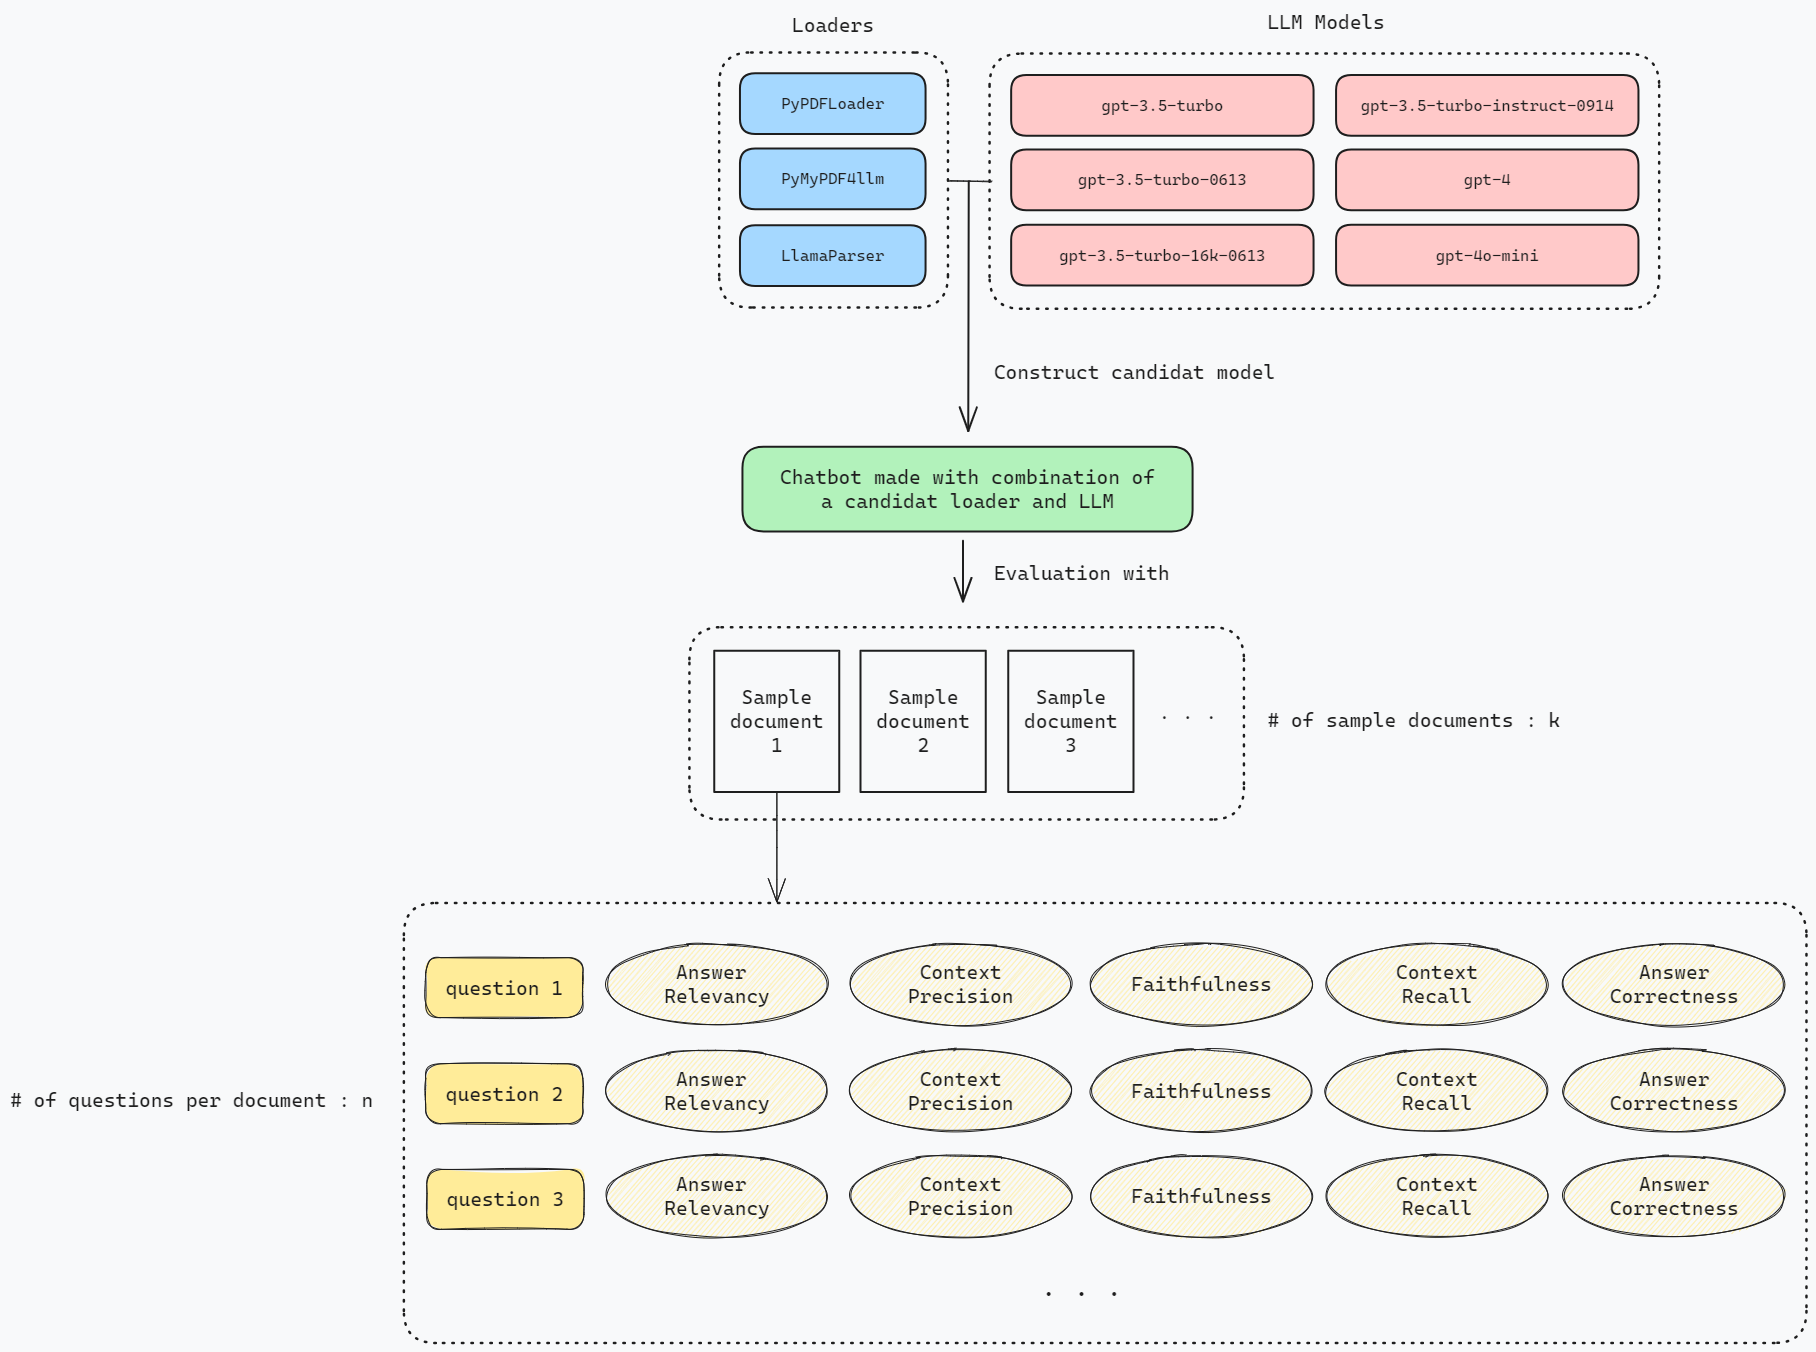

### Chatbot Performance Evaluation
**Depending on combination of loaders and LLM models**

In [61]:
import os
from dotenv import load_dotenv
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

In [62]:
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if OPENAI_API_KEY:
    print("API key loaded successfully.")
else:
    raise ValueError("Error loading API key. Check that OPENAI_API_KEY is set inside .env")

API key loaded successfully.


In [63]:
file_list = os.listdir("examplefiles")

# Filter only the list of sample files with qa dataset
# because evaluation is impossible without qa dataset
file_list = list(filter(lambda x : 
                os.path.exists(f"human_qa_dataset/qa_{x}".replace(".pdf", ".json")), 
                file_list))

In [64]:
file_list

['DB Concepts Chapter1.pdf',
 'DB Concepts Chapter2.pdf',
 'DB Concepts Chapter3.pdf']

In [ ]:
loader_list = ["LlamaParser", "PyPDFLoader", "PyMyPDF4llm"]
llm_list = ["gpt-3.5-turbo", "gpt-3.5-turbo-0125", "gpt-4o", "gpt-4o-2024-11-20", "gpt-4o-mini"]

In [66]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

def docs_splitter(docs):
    text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
    )
    all_splits = text_splitter.split_documents(docs)
    return all_splits

In [67]:
from langchain_community.document_loaders import PyPDFLoader
import pymupdf4llm
from llama_parse import LlamaParse
from llama_index.core import SimpleDirectoryReader
from langchain.text_splitter import CharacterTextSplitter
import nest_asyncio
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import utils as chromautils

# the vesion of PDF Loaders
# (1) PyPDFLoader
# (2) PyMyPDF4llm
# (3) LlamaParser

def make_embeddings(file_name, loaderType):
    FILE_PATH = os.path.join(os.getcwd(), "examplefiles", file_name)

    if loaderType == "PyPDFLoader": # source, page, start_index
        loader = PyPDFLoader(file_path=FILE_PATH)
        docs = loader.load()

    elif loaderType == "PyMyPDF4llm": # format, title, author, subject, file_path, start_index ...
        loader = pymupdf4llm.LlamaMarkdownReader()
        docs_llama = loader.load_data(file_path=FILE_PATH)
        doc_creator = CharacterTextSplitter()
        docs = doc_creator.create_documents(metadatas=list(map(lambda x : x.metadata, docs_llama)), 
                                    texts=list(map(lambda x : x.text, docs_llama)))
                                    
    elif loaderType == "LlamaParser": # file_path, file_name, file_type, file_size, creation_date, last_modified_date, start_index
        nest_asyncio.apply()
        parser = LlamaParse(
            result_type="markdown", 
            num_workers=8, 
            verbose=True
        )
        file_extractor = {".pdf": parser}
        docs_temp = SimpleDirectoryReader(
            input_files=[FILE_PATH],
            file_extractor=file_extractor,
        ).load_data()
        docs = [doc.to_langchain_format() for doc in docs_temp]
        
    else:
        print("Wrong loader type is entered.")
        return False

    all_splits = docs_splitter(docs)
    
    if loaderType == "PyMyPDF4llm":
        all_splits = chromautils.filter_complex_metadata(all_splits)

    try:
        vectorstore = Chroma.from_documents(documents=all_splits,
                                    embedding=OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY),
                                    persist_directory=f"data/{file_name}_{loaderType}")
        print("Embeded vector store is succesfully made.")
        return vectorstore
    except:
        print("Embedding is Failed ... ㅠㅠ")
        return False

In [68]:
class ChatBot_test():
    def __init__(self, file_name, llmType, loaderType):
        load_dotenv()

        self.llm_version = llmType

        CORPUS_PATH = os.path.join(os.getcwd(), "corpus")  
        CHROMA_PATH = os.path.join(os.getcwd(), f"data/{file_name}_{loaderType}")

        if not os.path.exists(CHROMA_PATH):
            print("Embeded vector store does not exist.")
            return False

        self.chat_history = [] 
        self.llm = ChatOpenAI(model=self.llm_version, temperature=0, openai_api_key=OPENAI_API_KEY)
        # => if time left, I'll do experiments on which temperature is ideal between 0 and 1

        self.vectorstore = Chroma(persist_directory=CHROMA_PATH, embedding_function=OpenAIEmbeddings())
        self.retriever = self.vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

        self.prompt = PromptTemplate(
            input_variables=["history", "context", "question"],
            template="""
            You are a knowledgeable assistant. Use the following pieces of retrieved context to answer the question.
            If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

            Conversation history:
            {history}

            Context:
            {context}

            Question:
            {question}

            Answer:
        """)

        print("ChatBot initialized successfully!")    

    def format_docs(self, docs):
            """Format the retrieved documents into a single context string for the prompt."""
            return "\n\n".join(doc.page_content for doc in docs)
        
    def format_history(self):
        """Format the chat history into a string for inclusion in the prompt."""
        return "\n".join(
            f"Q: {item['question']}\nA: {item['answer']}" for item in self.chat_history[-3:]
        )

    def answer(self, question):
        """Generate an answer using the RAG chain."""
        rag_chain = (
            {
                "history": RunnableLambda(lambda _: self.format_history()), 
                "context": self.retriever | self.format_docs,
                "question": RunnablePassthrough()
            }
            | self.prompt
            | self.llm
            | RunnableLambda(lambda x: x.content) 
        )

        response = rag_chain.invoke(question)
        self.chat_history.append({"question": question, "answer": response})

        return response

In [ ]:
import json
from datasets import Dataset
from ragas import EvaluationDataset, evaluate, RunConfig
from ragas.metrics import answer_relevancy, context_precision, faithfulness, context_recall, answer_correctness
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

def performance_eval(filename, loaderType, llmType):

    # (1) make_embeddings of given pdf files using candidat loader
    make_embeddings(file_name=filename, loaderType=loaderType)

    # (2) declare chatbot with argumnets : loaderType, llmType
    bot = ChatBot_test(file_name=filename, loaderType=loaderType, llmType=llmType)

    questions = []
    ground_truths = []
    answers = []
    contexts = []

    # (3) declare chroma vectorstore for RAG implementation
    CHROMA_PATH = os.path.join(os.getcwd(), f"data/{filename}_{loaderType}")
    vectorstore = Chroma(persist_directory=CHROMA_PATH, embedding_function=OpenAIEmbeddings())
    retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

    # (4 - 1) preprocessing human made dataset into qa dataset
    with open(f"human_qa_dataset/qa_{filename.replace('.pdf', '.json')}") as json_file:
        json_data = json.load(json_file)

    for qa in json_data:
        questions.append(qa["question"])
        ground_truths.append(qa["groudTruth"])

    for query in questions:
        answers.append(bot.answer(query))
        contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])

    data = {
        "user_input": questions,
        "reference": ground_truths,
        "response": answers,
        "retrieved_contexts": contexts
    }

    dataset = Dataset.from_dict(data)
    eval_dataset = EvaluationDataset.from_hf_dataset(dataset)

    llm_model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, openai_api_key=OPENAI_API_KEY)
    run_config = RunConfig(timeout=1200)

    result = evaluate(
        eval_dataset, 
        metrics = [answer_relevancy, context_precision, faithfulness, context_recall, answer_correctness], 
        llm = llm_model, 
        embeddings=OpenAIEmbeddings(), 
        raise_exceptions=False,
        batch_size=10,
        run_config =run_config
    )

    return result.to_pandas()

In [70]:
for loader in loader_list:
    for llm in llm_list:
        for file in file_list:
            result = performance_eval(filename=file, loaderType=loader, llmType=llm)
            result.to_csv(f"performance_result/{loader}_{llm}_{file}.csv")

ChatBot initialized successfully!


Evaluating: 100%|██████████| 75/75 [32:42<00:00, 26.17s/it]


ChatBot initialized successfully!


Evaluating: 100%|██████████| 75/75 [31:56<00:00, 25.55s/it]


ChatBot initialized successfully!


Evaluating: 100%|██████████| 75/75 [31:51<00:00, 25.48s/it]


ChatBot initialized successfully!


Evaluating: 100%|██████████| 75/75 [31:48<00:00, 25.45s/it]


ChatBot initialized successfully!


Batch 8/8:  40%|████      | 2/5 [01:00<01:21, 27.20s/it]  Exception raised in Job[74]: TimeoutError()
Exception raised in Job[71]: TimeoutError()
Evaluating: 100%|██████████| 75/75 [1:25:10<00:00, 68.14s/it] 


ChatBot initialized successfully!


Evaluating: 100%|██████████| 75/75 [01:29<00:00,  1.19s/it]
